# Imports

In [1]:
import wandb
from wandb.integration.keras import WandbCallback
wandb.login()

2024-06-11 07:46:23.813227: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alvaro-francisco-gil (orbit-generation). Use `wandb login --relogin` to force relogin


True

In [1]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)



2024-06-14 11:27:10.933389: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPUs found: 3
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU 2: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2024-06-14 11:27:13.010008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 11:27:13.693917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21330 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:18:00.0, compute capability: 8.6


In [2]:
from orbit_generation.constants import EM_MU
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits
from orbit_generation.stats import plot_histograms_comparison, plot_latent_space, plot_combined_latent_space
from orbit_generation.dataset import get_first_period_fixed_step_dataset, get_orbit_classes
from orbit_generation.model import get_optimizer
from orbit_generation.propagation import calculate_errors
from orbit_generation.experiment import setup_new_experiment, convert_notebook

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tensorflow import keras
import tsgm
import os

2024-06-14 11:27:29.427397: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-14 11:27:29.429648: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7dbed50


# Parameters

In [4]:
data_path = r"/orbit-generation/data/orbits_dt_0_01/EM_dt_fix_0_01.h5"
experiments_folder = "../experiments"

In [5]:
params = {
    'model_name': 'vae_conv5',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 32,
    'feature_dim': 6,
    'seq_len': 300,
    'batch_size': 32,
    'epochs': 25,
    'optimizer': {
        'name': 'Adam',
        'learning_rate': 0.001
    },
    'num_samples': 1000
}

In [7]:
# Initialize a new run
wandb.init(project='orbit-generation', entity='alvaro-francisco-gil', config=params)

wandb: Currently logged in as: alvaro-francisco-gil. Use `wandb login --relogin` to force relogin


# Data

## Import

In [6]:
data, orbit_df, labels, system_dict = get_first_period_fixed_step_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

Percentage of the dataset returned: 21.42%


(95005, 6, 300)

## Shuffle

In [7]:
# Set a random seed for reproducibility
np.random.seed(42) 

# Create an array of indices based on the length of the data
indices = np.arange(data.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder the data and labels
data = data[indices]
labels = np.array(labels)
labels = labels[indices]

## Transpose

In [8]:
transposed_orbits = np.transpose(data, (0, 2, 1))

## Scaling

In [9]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(95005, 300, 6)

# Modelling

## Define Architecture

In [13]:
# Accessing model configuration from the zoo using parameters from the dictionary
architecture = tsgm.models.zoo[params['model_name']](
    seq_len=params['seq_len'], 
    feat_dim=params['feature_dim'], 
    latent_dim=params['latent_dim']
)

# Extracting encoder and decoder from the architecture
encoder, decoder = architecture.encoder, architecture.decoder

## Training

In [14]:
# Assuming encoder and decoder have been defined as part of the architecture setup
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)

# Compile the VAE model with the configured optimizer from the params dictionary
optimizer = get_optimizer(params['optimizer'])
vae.compile(optimizer=optimizer)

# Fit the model using the scaled data and parameters from the dictionary
vae.fit(scaled_data, epochs=params['epochs'], batch_size=params['batch_size'], callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/25


2024-06-10 10:16:57.978521: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


   6/2969 [..............................] - ETA: 2:59 - loss: 581.8698 - reconstruction_loss: 565.6716 - kl_loss: 0.9323WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0273s vs `on_train_batch_end` time: 0.0286s). Check your callbacks.


2969/2969 [==============================] - 191s 63ms/step - loss: 140.9244 - reconstruction_loss: 62.2394 - kl_loss: 13.8826
Epoch 2/25
2969/2969 [==============================] - 185s 62ms/step - loss: 29.3500 - reconstruction_loss: 15.4612 - kl_loss: 11.7109
Epoch 3/25
2969/2969 [==============================] - 185s 62ms/step - loss: 20.6034 - reconstruction_loss: 10.8231 - kl_loss: 10.4563
Epoch 4/25
2969/2969 [==============================] - 179s 60ms/step - loss: 17.8464 - reconstruction_loss: 7.9921 - kl_loss: 9.6522
Epoch 5/25
2969/2969 [==============================] - 186s 63ms/step - loss: 21.3223 - reconstruction_loss: 12.3544 - kl_loss: 9.5280
Epoch 6/25
2969/2969 [==============================] - 187s 63ms/step - loss: 16.4183 - reconstruction_loss: 7.3404 - kl_loss: 9.2382
Epoch 7/25
2969/2969 [==============================] - 189s 64ms/step - loss: 26.6368 - reconstruction_loss: 11.3558 - kl_loss: 9.3283
Epoch 8/25
2969/2969 [==============================] - 1

## Saving

In [6]:
experiment_folder = setup_new_experiment(params, experiments_folder)

Parameters already exist for experiment: ../experiments/experiment_2


In [4]:
experiment_folder = '../experiments/experiment_3'

In [5]:
# Define full paths for saving
encoder_save_path = os.path.join(experiment_folder, 'encoder')
decoder_save_path = os.path.join(experiment_folder, 'decoder')
generated_data_path = os.path.join(experiment_folder, 'generated_data.npy')
static_all_orbit_path = os.path.join(experiment_folder, 'all_generated_data.png')
static_some_orbit_path = os.path.join(experiment_folder, 'some_generated_data.png')
dynamic_orbits_path = os.path.join(experiment_folder, 'generated_orbits.html')
latent_representations_path = os.path.join(experiment_folder, 'latent_representations.npy')
sampled_latent_representations_path = os.path.join(experiment_folder, 'sampled_latent_representations.npy')
labels_latent_representations_path = os.path.join(experiment_folder, 'labels_latent_representations.npy')
labels_sampled_latent_representations_path = os.path.join(experiment_folder, 'labels_sampled_latent_representations.npy')
latent_space_path = os.path.join(experiment_folder, 'dimensionality_reduction_latent_space')
combined_latent_space_path = os.path.join(experiment_folder, 'combined_dimensionality_reduction_latent_space')

In [17]:
# Save the models in the specified directory with TensorFlow format
encoder.save(encoder_save_path, save_format='tf')
decoder.save(decoder_save_path, save_format='tf')

INFO:tensorflow:Assets written to: ../experiments/experiment 3/encoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment 3/encoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment 3/decoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment 3/decoder/assets


[]

In [19]:
"""
encoder = tf.keras.models.load_model(encoder_save_path)
decoder = tf.keras.models.load_model(decoder_save_path)

# Assuming encoder and decoder have been defined as part of the architecture setup
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
"""

'\nencoder = tf.keras.models.load_model(encoder_save_path)\ndecoder = tf.keras.models.load_model(decoder_save_path)\n\n# Assuming encoder and decoder have been defined as part of the architecture setup\nvae = tsgm.models.cvae.BetaVAE(encoder, decoder)\n'

## Generate

In [17]:
samples_to_generate=100

generation = vae.generate(samples_to_generate)
generation.shape

TensorShape([100, 300, 6])

In [19]:
inverted_generation = scaler.inverse_transform(generation)
np.save(generated_data_path, inverted_generation)
inverted_generation.shape

TensorShape([100, 300, 6])

In [25]:
# generation = np.load(generated_data_path)

# Analysis of Generation

## Visualization

In [20]:
if inverted_generation.shape[2] == 7:
    inverted_generation = inverted_generation[:,:,1:]
    inverted_generation.shape

display_generation = np.transpose(inverted_generation, (0, 2, 1))
display_generation.shape

(100, 6, 300)

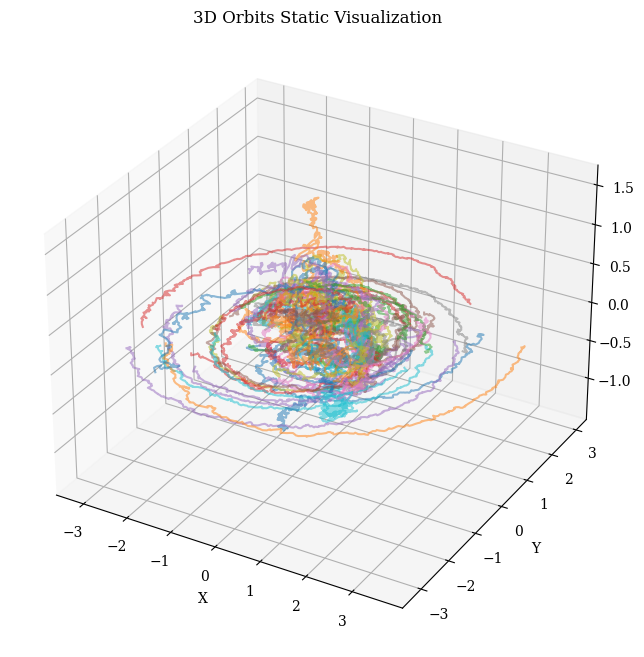

In [22]:
visualize_static_orbits(data= display_generation, show_legend=False, save_path=static_all_orbit_path)

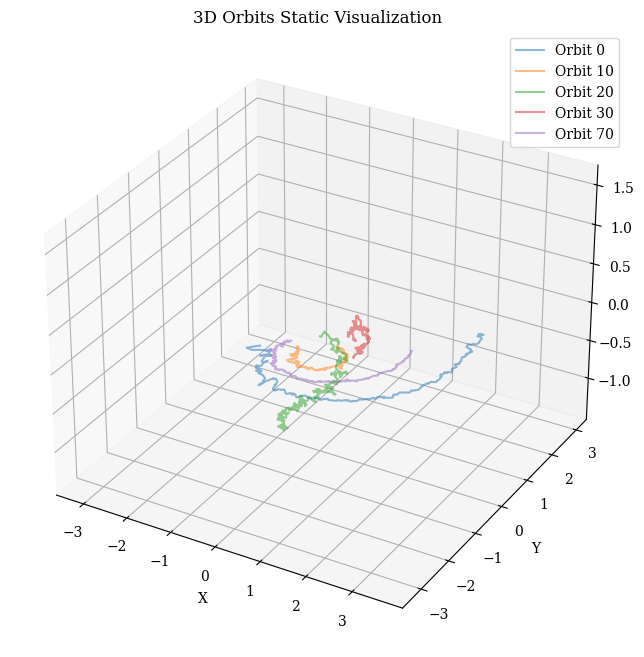

In [23]:
visualize_static_orbits(data= display_generation, orbit_indices=[0,10,20,30,70], save_path=static_some_orbit_path)

In [24]:
export_dynamic_orbits_html(data=display_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment 3/generated_orbits.html


## Coverage

In [25]:
data.shape

(95005, 6, 300)

In [28]:
inverted_ordered_generation = np.transpose(inverted_generation, (0, 2, 1))
inverted_ordered_generation.shape

(100, 6, 300)

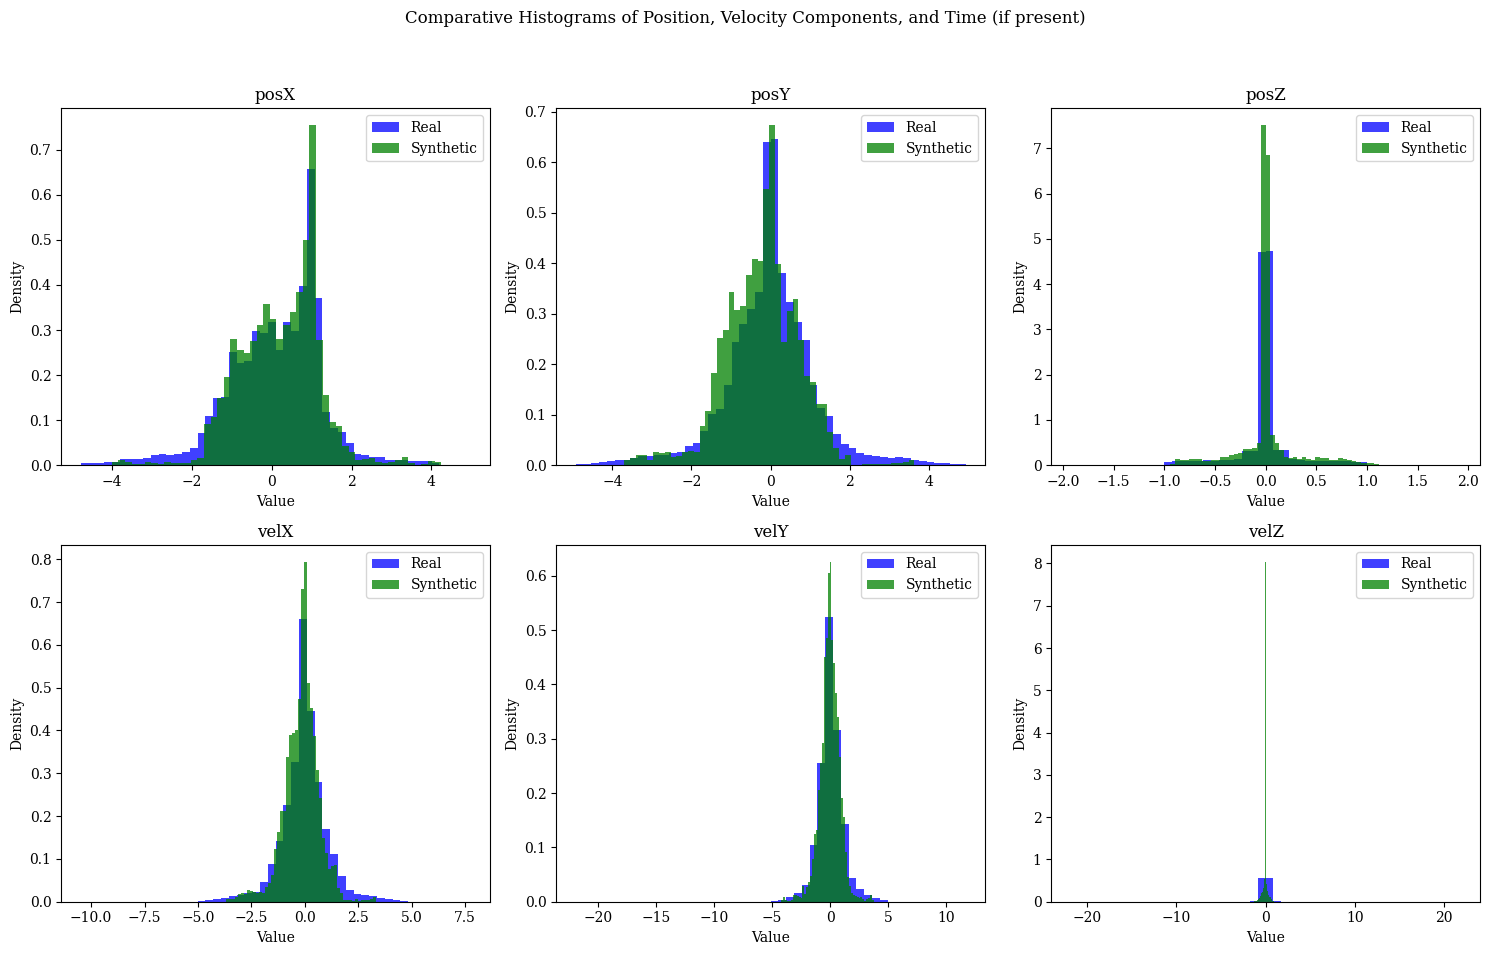

In [32]:
plot_histograms_comparison(data1=data, data2=inverted_ordered_generation, label1='Real', label2='Synthetic', normalize=True)

## Pheasibility

Cumulative position error for selected orbits: 827.6257658645475
Average position error per time step: 2.767979150048654


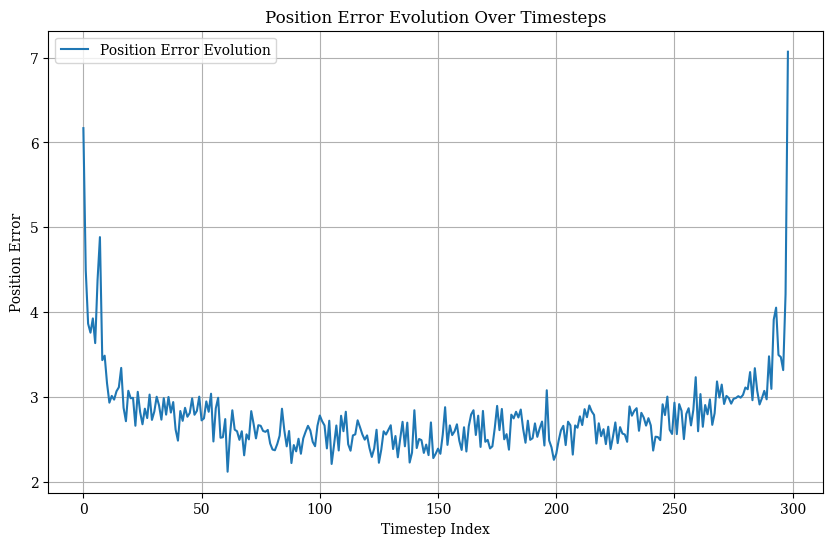

Cumulative velocity error for selected orbits: 1799.1278429687466
Average velocity error per time step: 6.017149976484102


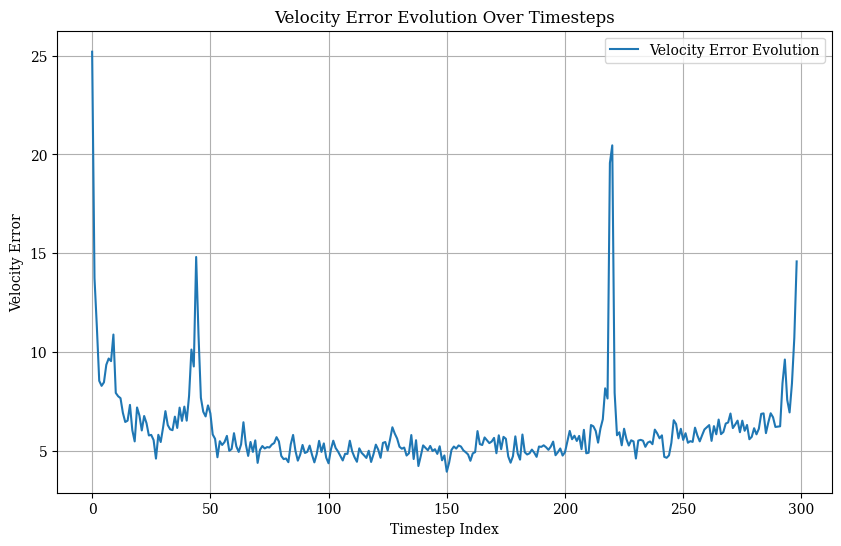

Cumulative energy error for selected orbits: 34972.308487695955
Average energy error per time step: 116.96424243376573


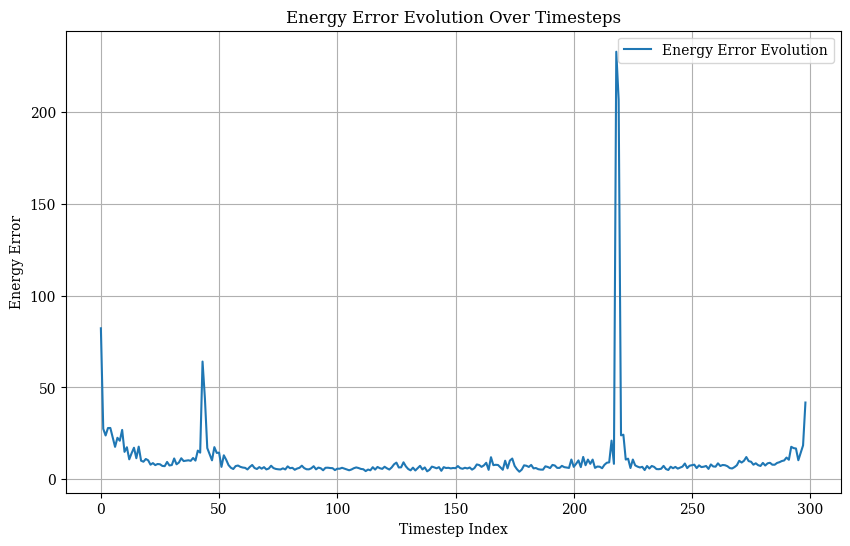

In [29]:
metrics = {} ## add model metrics
errors = calculate_errors(inverted_ordered_generation,EM_MU,time_step=0.01)

# Latent Visualization

In [ ]:
latent_mean, latent_deviation, latent_epsilon = vae.encoder(scaled_data)
latent_representations = latent_mean.numpy()

np.save(latent_representations_path, latent_representations)
np.save(labels_latent_representations_path, labels)

latent_representations.shape

## Sampling

In [30]:
np.random.seed(42)

# Randomly choose indices
random_indices = np.random.choice(data.shape[0], size=params['num_samples'], replace=False)

# Select the samples
sampled_data = scaled_data[random_indices]
sampled_labels = labels[random_indices]

sampled_data.shape

(1000, 300, 6)

In [32]:
latent_mean, latent_deviation, latent_epsilon = vae.encoder(sampled_data)
sampled_latent_representations = latent_mean.numpy()

np.save(sampled_latent_representations_path, sampled_latent_representations)
np.save(labels_sampled_latent_representations_path, sampled_labels)

sampled_latent_representations.shape

(1000, 32)

In [44]:
sampled_id_classes = [orbit_df.at[index, 'id_class'] for index in sampled_labels]
sampled_classes=get_orbit_classes(sampled_id_classes)

1000

## Orbit Classifications

Saved grid plot to ../experiments/experiment 3/dimensionality_reduction_latent_space_label_grid.png


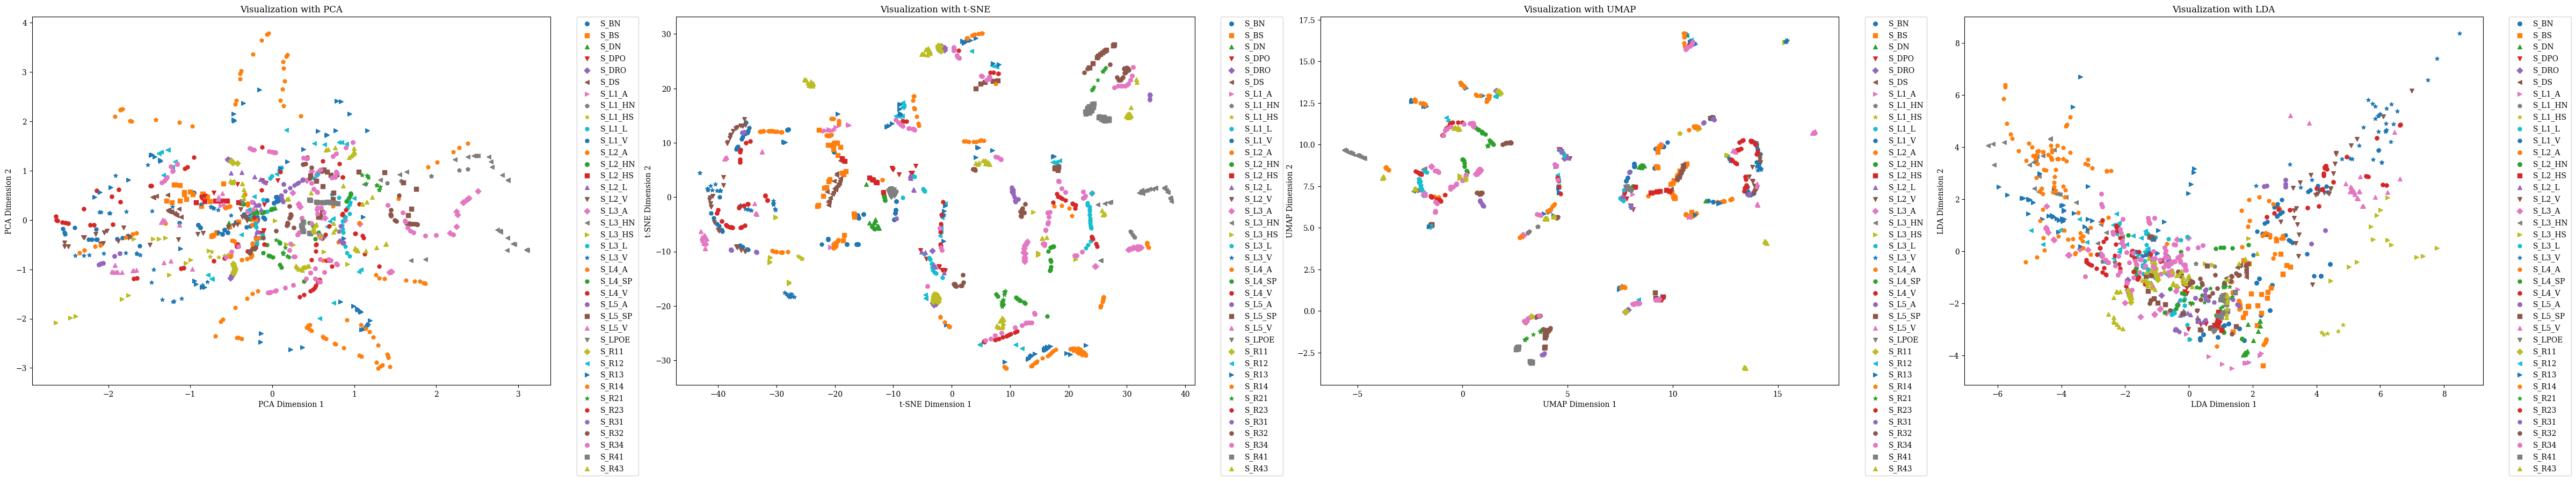

In [71]:
plot_latent_space(sampled_latent_representations, np.array(sampled_classes[0]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_label', many_classes=True)

Saved grid plot to ../experiments/experiment 3/dimensionality_reduction_latent_space_type_grid.png


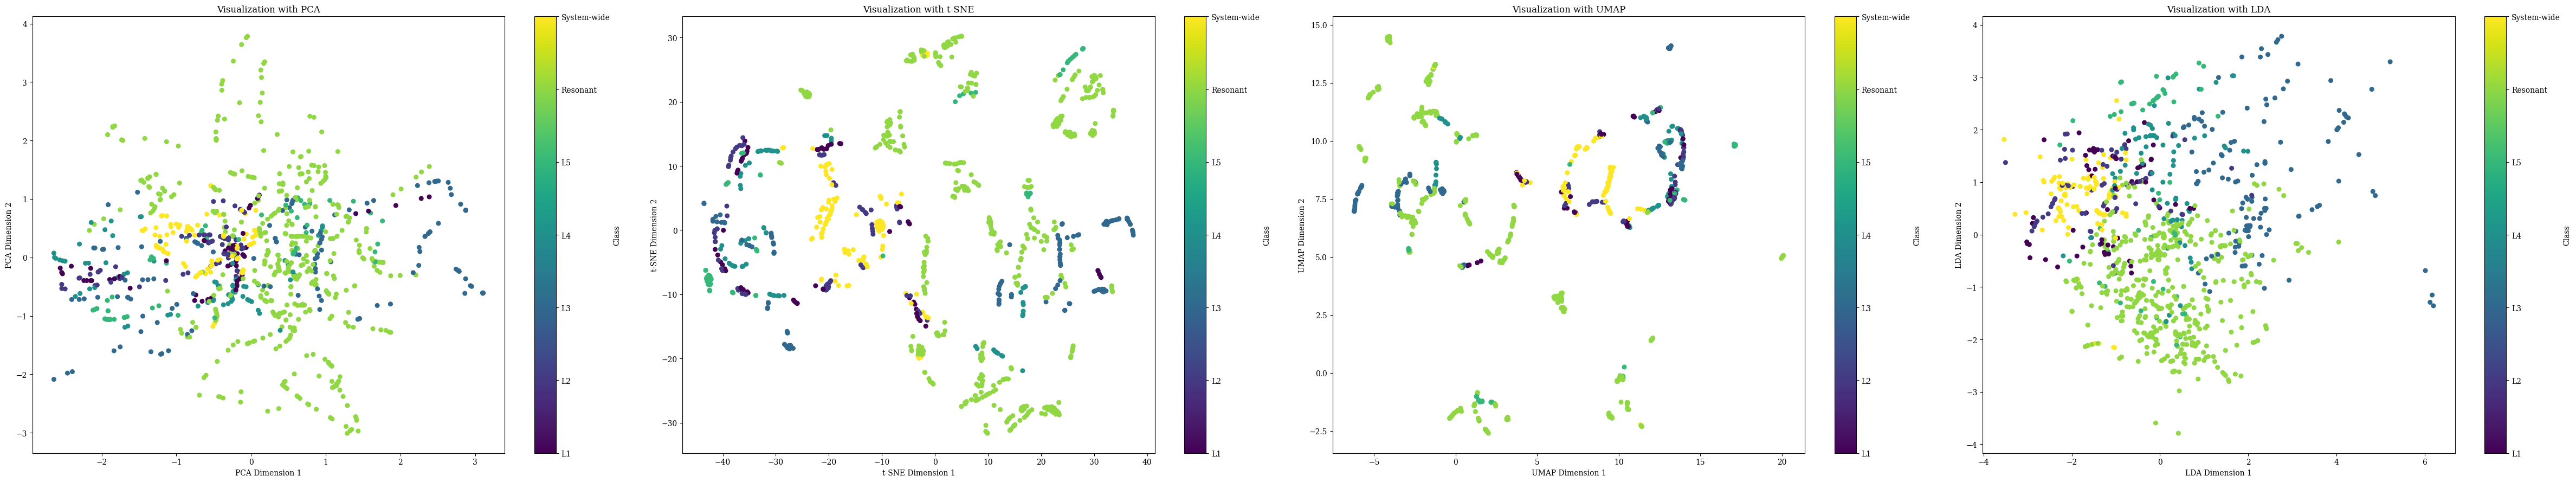

In [72]:
plot_latent_space(sampled_latent_representations, np.array(sampled_classes[1]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_type')

Saved grid plot to ../experiments/experiment 3/dimensionality_reduction_latent_space_subtype_grid.png


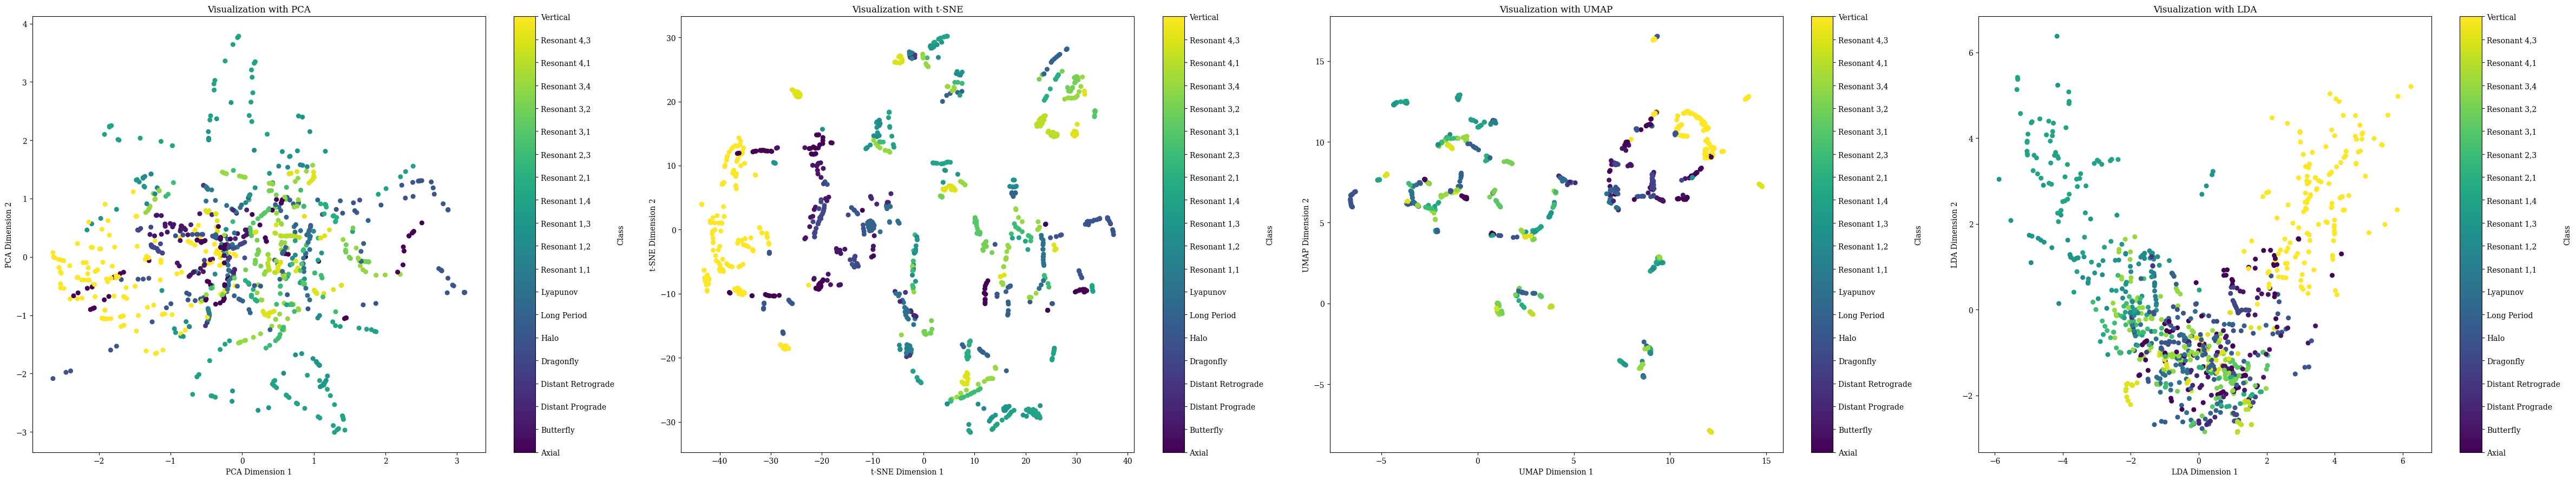

In [73]:
plot_latent_space(sampled_latent_representations, np.array(sampled_classes[2]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_subtype')

Saved grid plot to ../experiments/experiment 3/dimensionality_reduction_latent_space_direction_grid.png


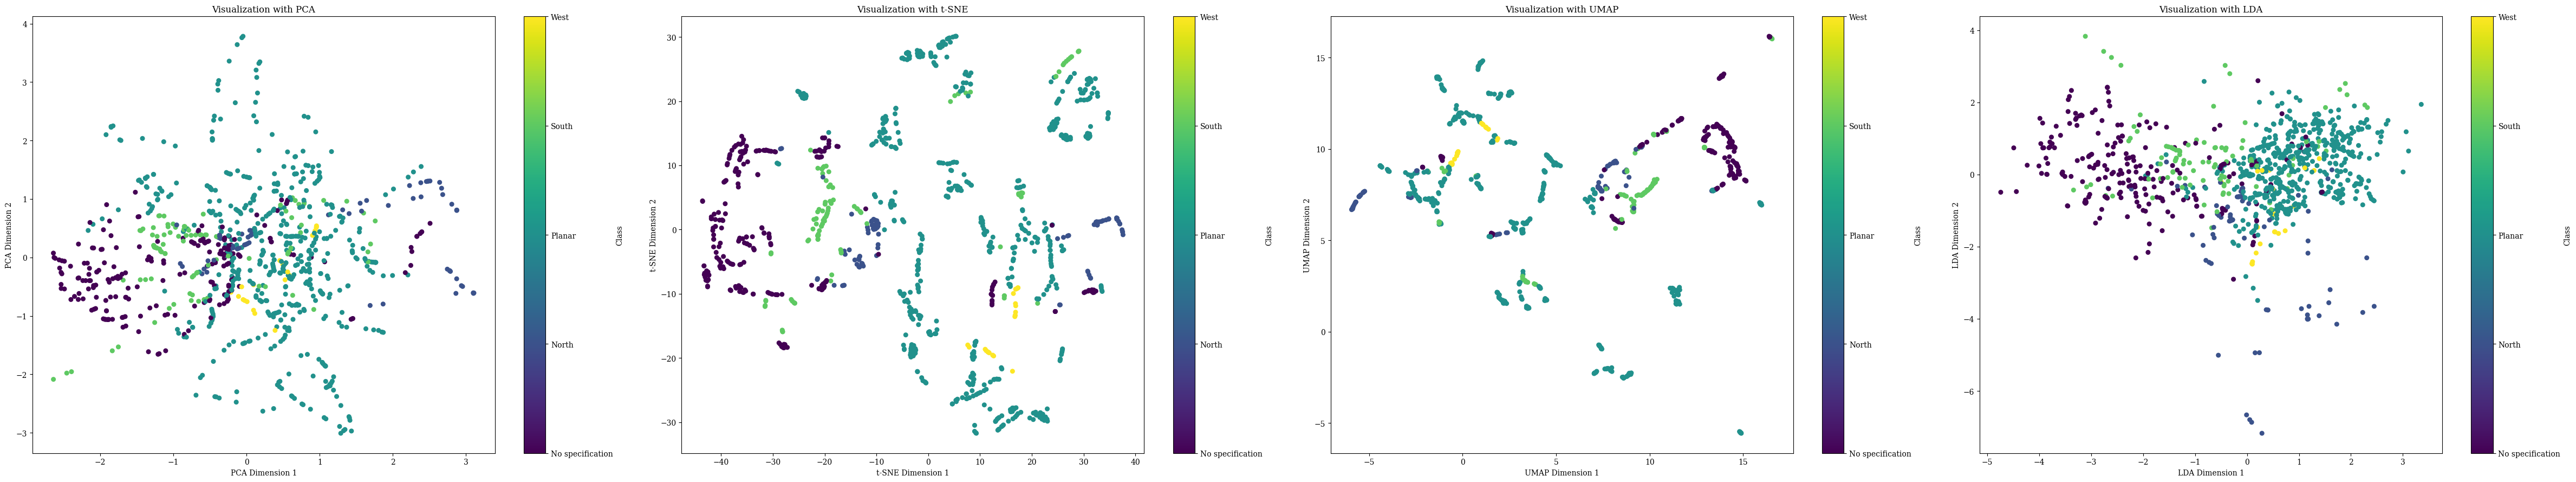

In [74]:
plot_latent_space(sampled_latent_representations, np.array(sampled_classes[3]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_direction')

## Synthetic vs Real

 1/35 [..............................] - ETA: 1s

35/35 [==============================] - 0s 5ms/step
(1100, 32)
Saved grid plot to ../experiments/experiment 3/combined_dimensionality_reduction_latent_space_grid.png


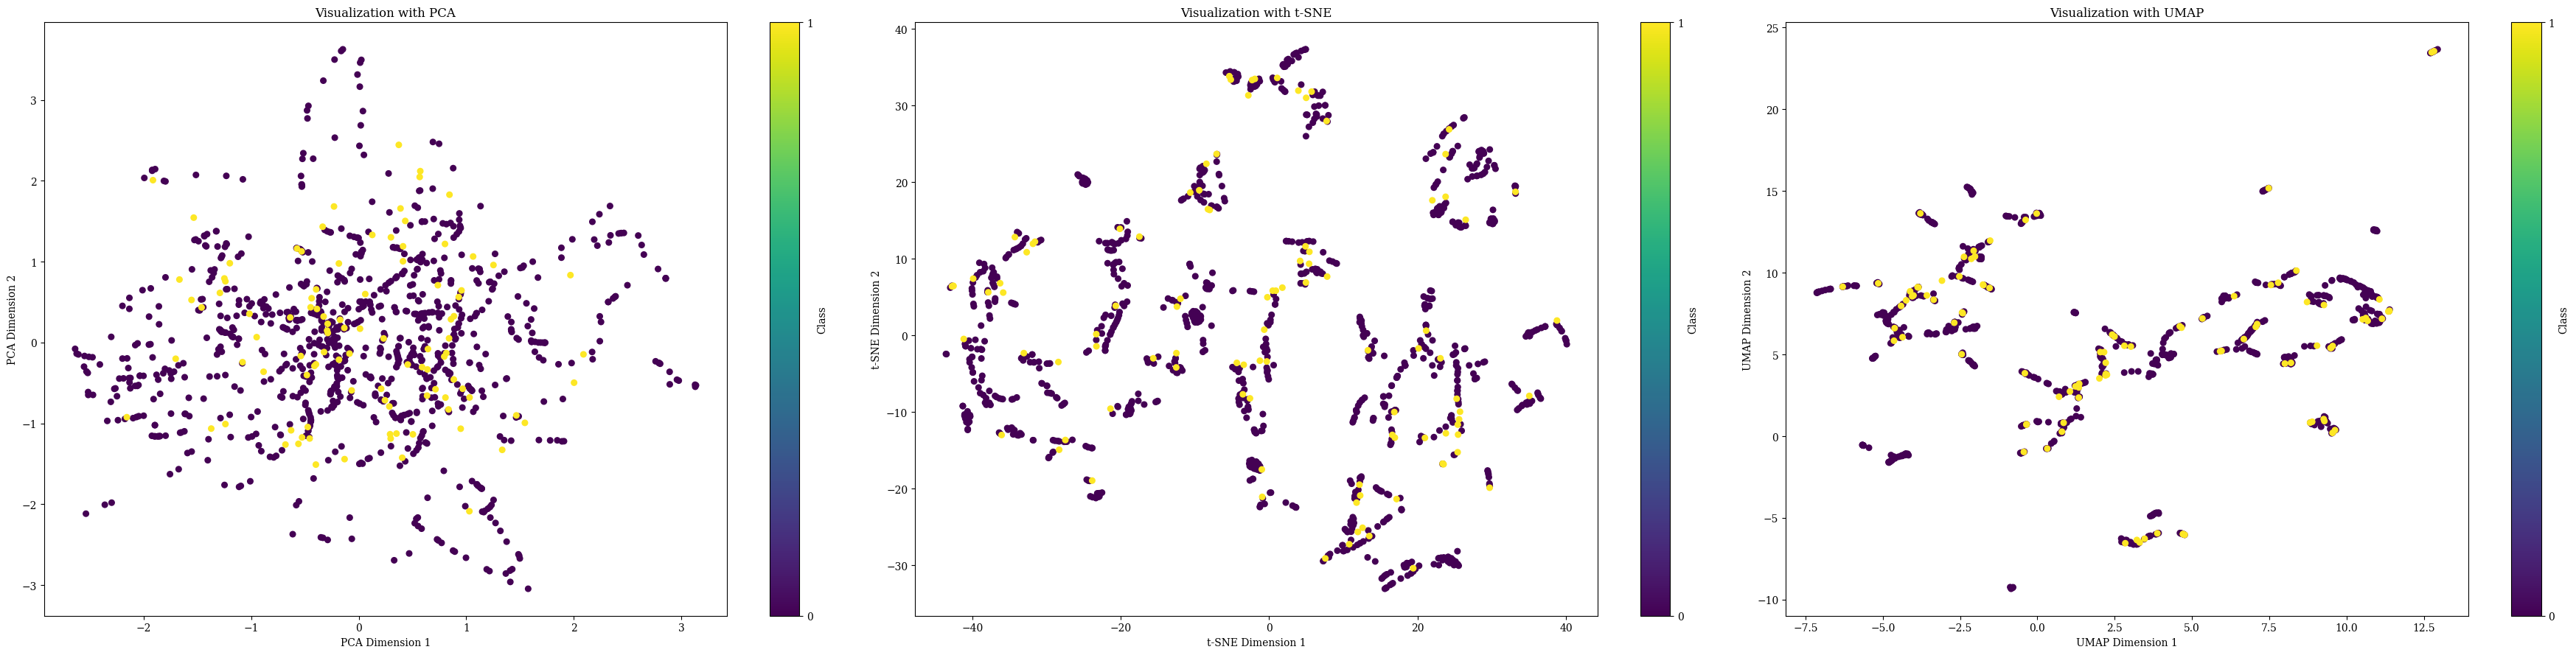

In [86]:
plot_combined_latent_space(sampled_data, generation, encoder, ['PCA','t-SNE','UMAP'], save_path=combined_latent_space_path, grid_view=True)

In [47]:
wandb.finish()

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
kl_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,█▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
kl_loss,8.51377
loss,12.98473
reconstruction_loss,4.47095


In [7]:
# Save notebook as experiment
notebook_path = '/orbit-generation/nbs_experiments/01_cvae.ipynb'  # Update this to the path of your notebook
convert_notebook(notebook_path, experiment_folder, os.path.basename(experiment_folder), format='html')

Notebook converted to HTML and saved at ../experiments/experiment_2/experiment_2.html
